In [1]:
import os
from PIL import Image

# Define the paths
source_folder = '/Users/nely/Desktop/TinyML/Project/Augmented and Rasterized'
destination_folder = '/Users/nely/Desktop/TinyML/Project/Augmented and Rasterized Gray'

# Create the destination folder 
os.makedirs(destination_folder, exist_ok=True)

# Process each file in the source folder
for filename in os.listdir(source_folder):
    if filename.endswith(".png"):  # check if it's an image
        file_path = os.path.join(source_folder, filename)
        img = Image.open(file_path).convert('L')  # convert image to grayscale
        new_filename = filename.replace(".png", "_gray.png")
        new_file_path = os.path.join(destination_folder, new_filename)
        img.save(new_file_path)  # save the grayscale image with the new name

print("All images have been converted to grayscale and saved in the new folder.")


All images have been converted to grayscale and saved in the new folder.


In [2]:
import os
import glob
import numpy as np
import math

def save_data_list(data_list, directory, prefix):
    """Save a list of file paths to a text file."""
    with open(os.path.join(directory, f'{prefix}_files.txt'), 'w') as file:
        for item in data_list:
            file.write(f"{item}\n")

# Directory containing GRAYSCALE augmented and rasterized gesture data
data_dir = '/Users/nely/Desktop/TinyML/Project/Augmented and Rasterized Gray'
# Load all .png files
data_files = glob.glob(f"{data_dir}/*.png")

# Filter out files without a label (unlabeled files start with an underscore or do not start with a number)
labeled_files = [file for file in data_files if os.path.basename(file)[0].isdigit()]

# Shuffle the files to ensure randomness in data split
np.random.shuffle(labeled_files)

# Define split percentages
test_percentage = 10
validation_percentage = 10
train_percentage = 80  # This should sum to 100%

# Calculate the number of items for each dataset
test_count = math.floor((len(labeled_files) * test_percentage) / 100)
validation_count = math.floor((len(labeled_files) * validation_percentage) / 100)

# Split the data
test_files = labeled_files[:test_count]
validation_files = labeled_files[test_count:(test_count + validation_count)]
train_files = labeled_files[(test_count + validation_count):]

# Save lists of file paths with '_gray' in the filenames
save_data_list(test_files, data_dir, "test_gray")
save_data_list(validation_files, data_dir, "validation_gray")
save_data_list(train_files, data_dir, "train_gray")

# Print counts to verify the splits
print(f"Total labeled files: {len(labeled_files)}")
print(f"Training files: {len(train_files)} ({train_percentage}%)")
print(f"Validation files: {len(validation_files)} ({validation_percentage}%)")
print(f"Test files: {len(test_files)} ({test_percentage}%)")



Total labeled files: 3951
Training files: 3161 (80%)
Validation files: 395 (10%)
Test files: 395 (10%)


In [3]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Constants
data_dir = '/Users/nely/Desktop/TinyML/Project/Augmented and Rasterized Gray'
image_size = (32, 32)
batch_size = 32

# Create a single ImageDataGenerator instance to rescale images
datagen_gray = ImageDataGenerator(rescale=1./255)

# Load image paths and labels from the text file for the test data
df_test_gray = pd.read_csv(data_dir + '/test_gray_files.txt', header=None, names=['filename'])


# Extract labels from the filenames
df_test_gray['label'] = df_test_gray['filename'].apply(lambda x: x.split('/')[-1].split('_')[0])

# Convert labels to strings for categorical mode
df_test_gray['label'] = df_test_gray['label'].astype(str)

# Setup the generator for test data using the DataFrame
test_generator_gray = datagen_gray.flow_from_dataframe(
    dataframe=df_test_gray,
    directory=None,  # No directory path needed as full paths are given in the DataFrame
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Set to grayscale for grayscale images
    shuffle=False  # Important not to shuffle test data to have consistent evaluation
)

# Load image paths for the training data
df_train_gray = pd.read_csv(data_dir + '/train_gray_files.txt', header=None, names=['filename'])

# Extract labels from the filenames
df_train_gray['label'] = df_train_gray['filename'].apply(lambda x: x.split('/')[-1].split('_')[0])

# Convert labels to strings for categorical mode
df_train_gray['label'] = df_train_gray['label'].astype(str)

# Setup the generator for training data using the DataFrame
train_generator_gray = datagen_gray.flow_from_dataframe(
    dataframe=df_train_gray,
    directory=None,  # No directory path needed as full paths are given in the DataFrame
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Set to grayscale
    shuffle=True  # Shuffle training data for better training
)

# Load image paths for the validation data
df_validation_gray = pd.read_csv(data_dir + '/validation_gray_files.txt', header=None, names=['filename'])

# Extract labels from the filenames
df_validation_gray['label'] = df_validation_gray['filename'].apply(lambda x: x.split('/')[-1].split('_')[0])

# Convert labels to strings for categorical mode
df_validation_gray['label'] = df_validation_gray['label'].astype(str)

# Setup the generator for validation data using the DataFrame
validation_generator_gray = datagen_gray.flow_from_dataframe(
    dataframe=df_validation_gray,
    directory=None,  # No directory path needed as full paths are given in the DataFrame
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Set to grayscale
    shuffle=False  # No need to shuffle validation data
)


Found 395 validated image filenames belonging to 5 classes.
Found 3161 validated image filenames belonging to 5 classes.
Found 395 validated image filenames belonging to 5 classes.


In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.callbacks import Callback
import time

# Constants
data_dir = '/Users/nely/Desktop/TinyML/Project/Augmented and Rasterized Gray'
image_size = (32, 32)  # this is the size of rasterized images
num_classes = 5  # Five gestures
batch_size = 32  # Modify if needed

# CNN Architecture adapted to grayscale images.
def make_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # First Conv Block
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Second Conv Block
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Third Conv Block
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Final Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

class TimingCallback(Callback):
    def __init__(self):
        self.times = []
        self.total_time = time.time()
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)
        print(f"Epoch {epoch+1}: {self.times[-1]:.2f} seconds")
    
    def on_train_end(self, logs=None):
        print(f"Total training time: {(time.time() - self.total_time):.2f} seconds")

# Instantiate the timing callback
timing_callback = TimingCallback()

# Model instantiation and summary
model_gray = make_model((32, 32, 1), num_classes)  # Note the change in input shape for grayscale
model_gray.summary()

# Model compilation
model_gray.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model with the timing callback using grayscale data generators
model_gray.fit(
    train_generator_gray,
    steps_per_epoch=train_generator_gray.n // batch_size,
    epochs=50,
    validation_data=validation_generator_gray,
    validation_steps=validation_generator_gray.n // batch_size,
    callbacks=[timing_callback]
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0     

In [5]:
from keras.models import Model, save_model, load_model
from keras.callbacks import Callback, ModelCheckpoint
import time
import json

# Define a callback to save the training history
class HistorySaver(Callback):
    def __init__(self, file_path):
        self.file_path = file_path

    def on_train_begin(self, logs=None):
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        with open(self.file_path, 'w') as file:
            json.dump(self.history, file)

# Define a callback to print training and validation accuracy
class AccuracyPrinter(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} - Training Accuracy: {logs['accuracy']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")

# Constants
data_dir = '/Users/nely/Desktop/TinyML/Project/Augmented and Rasterized Gray'
image_size = (32, 32)  # this is the size of our rasterized images
num_classes = 5  # Five gestures
batch_size = 32  # Modify as needed

# Instantiate the timing callback
timing_callback = TimingCallback()

# Instantiate the history saver callback
history_saver_gray = HistorySaver('training_history_gray.json')

# Instantiate the accuracy printer callback
accuracy_printer_gray = AccuracyPrinter()

# Model instantiation and summary for grayscale images
model_gray = make_model((32, 32, 1), num_classes)  # Adjust for grayscale input
model_gray.summary()

# Model compilation
model_gray.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to save the model checkpoints
checkpoint_path_gray = "model_checkpoint_gray.h5"
checkpoint_callback_gray = ModelCheckpoint(checkpoint_path_gray, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Training the model with the timing callback and saving history
history_gray = model_gray.fit(
    train_generator_gray,
    steps_per_epoch=train_generator_gray.n // batch_size,
    epochs=50,
    validation_data=validation_generator_gray,
    validation_steps=validation_generator_gray.n // batch_size,
    callbacks=[timing_callback, history_saver_gray, checkpoint_callback_gray, accuracy_printer_gray]
)

# Print testing accuracy
test_loss_gray, test_accuracy_gray = model_gray.evaluate(test_generator_gray, verbose=1)
print(f'Testing Accuracy: {test_accuracy_gray:.4f}')

# Save the final model
save_model(model_gray, 'final_model_gray.h5')


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0   

/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/98 [============================>.] - ETA: 0s - loss: 0.4021 - accuracy: 0.8630Epoch 2: 1.56 seconds

Epoch 2: val_loss did not improve from 3.75748
Epoch 2 - Training Accuracy: 0.8658 - Validation Accuracy: 0.1823
98/98 [==============================] - 2s 16ms/step - loss: 0.3982 - accuracy: 0.8658 - val_loss: 5.7703 - val_accuracy: 0.1823
Epoch 3/50
96/98 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9233Epoch 3: 1.56 seconds

Epoch 3: val_loss did not improve from 3.75748
Epoch 3 - Training Accuracy: 0.9243 - Validation Accuracy: 0.1823
98/98 [==============================] - 2s 16ms/step - loss: 0.2457 - accuracy: 0.9243 - val_loss: 7.8876 - val_accuracy: 0.1823
Epoch 4/50
97/98 [============================>.] - ETA: 0s - loss: 0.1902 - accuracy: 0.9390Epoch 4: 1.57 seconds

Epoch 4: val_loss did not improve from 3.75748
Epoch 4 - Training Accuracy: 0.9351 - Validation Accuracy: 0.1823
98/98 [==============================] - 2s 16ms/step - loss: 0.

/var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/ipykernel_43825/3319230123.py:66: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_gray, 'final_model_gray.h5')


13/13 [==============================] - 0s 8ms/step


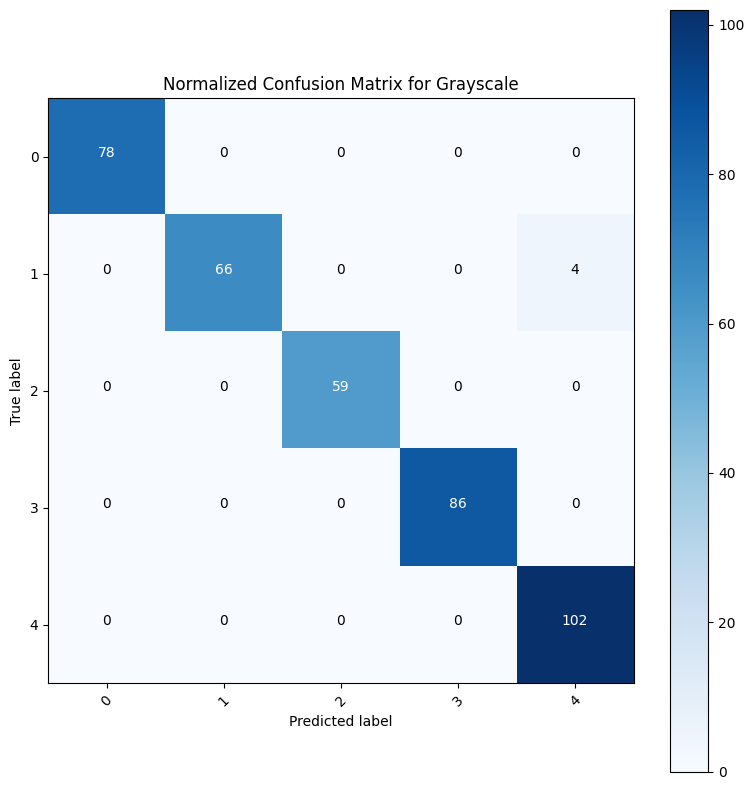

Classification Report for Grayscale Model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      0.94      0.97        70
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        86
           4       0.96      1.00      0.98       102

    accuracy                           0.99       395
   macro avg       0.99      0.99      0.99       395
weighted avg       0.99      0.99      0.99       395



In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Predict the test data using the grayscale model
y_pred_gray = model_gray.predict(test_generator_gray)
y_pred_classes_gray = np.argmax(y_pred_gray, axis=1)

# Actual labels from the grayscale test generator
y_true_gray = test_generator_gray.classes

# Compute confusion matrix
cm_gray = confusion_matrix(y_true_gray, y_pred_classes_gray)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_gray, classes=test_generator_gray.class_indices.keys(), title='Normalized Confusion Matrix for Grayscale')
plt.show()

# Print classification report for the grayscale model
print('Classification Report for Grayscale Model')
print(classification_report(y_true_gray, y_pred_classes_gray, target_names=test_generator_gray.class_indices.keys()))


13/13 [==============================] - 0s 8ms/step


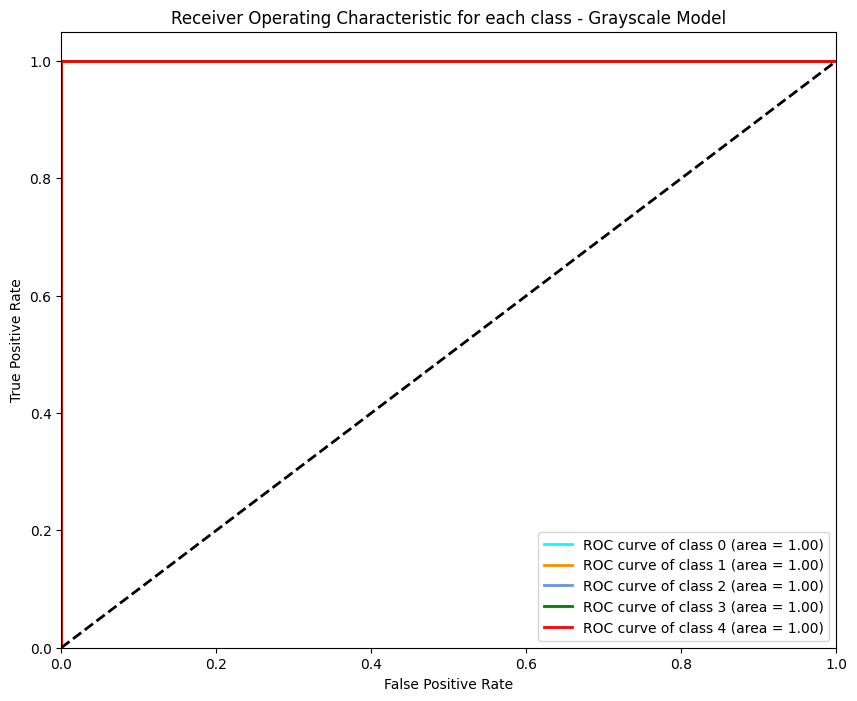

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


n_classes = 5 

# Actual labels and predictions from grayscale test data
y_true_gray = test_generator_gray.classes
y_pred_prob_gray = model_gray.predict(test_generator_gray)  # Model predictions (probabilities)

# Convert true labels to binary format for ROC calculation
y_true_binary_gray = label_binarize(y_true_gray, classes=list(range(n_classes)))

# Initialize variables to hold ROC curve metrics
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    if np.any(y_true_binary_gray[:, i]):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary_gray[:, i], y_pred_prob_gray[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        fpr[i], tpr[i], roc_auc[i] = [None], [None], None

# Plot all ROC curves if applicable
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    if fpr[i] is not None and tpr[i] is not None:
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    else:
        print(f"No positive samples for class {i}, skipping ROC curve.")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class - Grayscale Model')
plt.legend(loc="lower right")
plt.show()


In [8]:
from tensorflow import keras

# Load the final grayscale model saved after training
model_gray = keras.models.load_model('final_model_gray.h5')


In [9]:
import tensorflow as tf
import glob
from tensorflow import keras
import os
import time

# Load the final grayscale model saved after training
model_gray = keras.models.load_model('final_model_gray.h5')

# Setup the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_gray)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Function to create a representative dataset generator for grayscale images
def representative_dataset_gen():
    for filename in glob.glob('/Users/nely/Desktop/TinyML/Project/Augmented and Rasterized Gray/*.png'):
        img = keras.preprocessing.image.load_img(filename, target_size=(32, 32), color_mode='grayscale')
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
        img_array = tf.cast(img_array, tf.float32)  # Ensure float32 input type
        yield [img_array]

# Apply quantization to the converter
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # Ensures model uses int8 input
converter.inference_output_type = tf.int8  # Ensures model uses int8 output

# Convert the model
tflite_quant_model = converter.convert()

# Save the quantized model
quantized_model_path = 'gesture_model_quantized_gray.tflite'
with open(quantized_model_path, 'wb') as f:
    f.write(tflite_quant_model)

# Print the size of the quantized model
model_size = os.path.getsize(quantized_model_path)
print(f"Size of the quantized model: {model_size} bytes")

# Optional: converting bytes to kilobytes 
print(f"Size of the quantized model: {model_size / 1024:.2f} KB")


INFO:tensorflow:Assets written to: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/tmps8p20flw/assets


INFO:tensorflow:Assets written to: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/tmps8p20flw/assets
/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-05-09 09:04:02.451872: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-09 09:04:02.452015: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-09 09:04:02.454447: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/tmps8p20flw
2024-05-09 09:04:02.455883: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-05-09 09:04:02.455887: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/

Size of the quantized model: 121472 bytes
Size of the quantized model: 118.62 KB


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [32]:
import tensorflow as tf
import glob
from tensorflow import keras
import os
import time

# Load the final grayscale model saved after training
model_gray = keras.models.load_model('final_model_gray.h5')

# Print the size of the original Keras grayscale model
final_model_gray_path = 'final_model_gray.h5'
final_model_gray_size = os.path.getsize(final_model_gray_path)
print(f"Size of the final Keras grayscale model: {final_model_gray_size} bytes")
print(f"Size of the final Keras grayscale model: {final_model_gray_size / 1024:.2f} KB")

# Setup the converter for quantization of the grayscale model
converter = tf.lite.TFLiteConverter.from_keras_model(model_gray)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Function to create a representative dataset generator for grayscale images
def representative_dataset_gen():
    for filename in glob.glob('/Users/nely/Desktop/TinyML/Project/Augmented and Rasterized Gray/*.png'):
        img = keras.preprocessing.image.load_img(filename, target_size=(32, 32), color_mode='grayscale')
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
        img_array = tf.cast(img_array, tf.float32)  # Ensure float32 input type
        yield [img_array]

# Apply quantization to the converter
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # Ensures model uses int8 input
converter.inference_output_type = tf.int8  # Ensures model uses int8 output

# Convert the grayscale model
tflite_quant_model_gray = converter.convert()

# Save the quantized grayscale model
quantized_model_gray_path = 'gesture_model_quantized_gray.tflite'
with open(quantized_model_gray_path, 'wb') as f:
    f.write(tflite_quant_model_gray)

# Print the size of the quantized grayscale model
quantized_model_gray_size = os.path.getsize(quantized_model_gray_path)
print(f"Size of the quantized grayscale model: {quantized_model_gray_size} bytes")
print(f"Size of the quantized grayscale model: {quantized_model_gray_size / 1024:.2f} KB")


Size of the final Keras grayscale model: 1420800 bytes
Size of the final Keras grayscale model: 1387.50 KB
INFO:tensorflow:Assets written to: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/tmpf2oft3i1/assets


INFO:tensorflow:Assets written to: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/tmpf2oft3i1/assets
/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-05-09 10:06:46.607713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-09 10:06:46.607968: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-09 10:06:46.609687: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/tmpf2oft3i1
2024-05-09 10:06:46.610913: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-05-09 10:06:46.610917: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/

Size of the quantized grayscale model: 121472 bytes
Size of the quantized grayscale model: 118.62 KB


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [36]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd

# Define the TensorFlow Lite quantized model filename for the grayscale model
QUANTIZED_TFL_MODEL_FILENAME = 'gesture_model_quantized_gray.tflite'

# Define the output C source file name including 'gray' to denote the grayscale model
TFL_CC_MODEL_FILENAME = 'gesture_model_data_gray.cc'

# Convert to a C source file, a TensorFlow Lite for Microcontroller model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}

# Updated variable names in the C source file to be more descriptive and specific to the grayscale model
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/{REPLACE_TEXT}/gesture_model_data_gray/g' {TFL_CC_MODEL_FILENAME}

# Print the first 100 lines of the C source file to verify
print("These are the first 100 lines of the C source file:")
!head -n 100 {TFL_CC_MODEL_FILENAME}

# Print the last 100 lines of the C source file to verify
print("\nThese are the last 100 lines of the C source file:")
!tail -n 100 {TFL_CC_MODEL_FILENAME}


zsh:1: command not found: apt-get
sed: 1: "gesture_model_data_gray.cc": extra characters at the end of g command
These are the first 100 lines of the C source file:
unsigned char gesture_model_quantized_gray_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00,
  0xb8, 0xb3, 0x01, 0x00, 0xc8, 0xb3, 0x01, 0x00, 0xd4, 0xd9, 0x01, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0a, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0

In [38]:
# QAT Quantization Aware Training (sugegsted by Dinuka to do this)

import tensorflow as tf
import tensorflow_model_optimization as tfmot
import glob
from tensorflow import keras
import os

# Load the final grayscale model saved after training
model_gray = keras.models.load_model('final_model_gray.h5')

# Apply quantization-aware training using TensorFlow Model Optimization Toolkit
quantize_model = tfmot.quantization.keras.quantize_model
quant_aware_model_gray = quantize_model(model_gray)

# Compile the quantization-aware model
quant_aware_model_gray.compile(optimizer='adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])


####  If we have x_train and y_train prepared for retraining/fine-tuning (IF NEEDED) #######
#### quant_aware_model_gray.fit(x_train, y_train, epochs=5) # Adjust parameters and uncomment as needed ####


# Save the quantization-aware model to check its size
quant_aware_model_gray_path = 'quant_aware_model_gray_QAT.h5'
quant_aware_model_gray.save(quant_aware_model_gray_path)

# Print the size of the quantization-aware Keras model
quant_aware_model_gray_size = os.path.getsize(quant_aware_model_gray_path)
print(f"Size of the quantization-aware Keras model: {quant_aware_model_gray_size} bytes")
print(f"Size of the quantization-aware Keras model: {quant_aware_model_gray_size / 1024:.2f} KB")

# Convert the quantization-aware model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model_gray)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Function to create a representative dataset generator for grayscale images
def representative_dataset_gen():
    for filename in glob.glob('/Users/nely/Desktop/TinyML/Project/Augmented and Rasterized Gray/*.png'):
        img = keras.preprocessing.image.load_img(filename, target_size=(32, 32), color_mode='grayscale')
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
        img_array = tf.cast(img_array, tf.float32)  # Ensure float32 input type
        yield [img_array]

# Apply representative data for quantization
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # Ensures model uses int8 input
converter.inference_output_type = tf.int8  # Ensures model uses int8 output

# Convert the quantization-aware model to TFLite format
tflite_quant_model_gray = converter.convert()

# Save the quantized grayscale TFLite model
quantized_tflite_gray_path = 'gesture_model_quantized_gray_QAT.tflite'
with open(quantized_tflite_gray_path, 'wb') as f:
    f.write(tflite_quant_model_gray)


# Print the size of the quantized grayscale QAT TFLite model
quantized_model_gray_size = os.path.getsize(quantized_tflite_gray_path)
print(f"Size of the quantized grayscale QAT TFLite model: {quantized_model_gray_size} bytes")
print(f"Size of the quantized grayscale QAT TFLite model: {quantized_model_gray_size / 1024:.2f} KB")



/Applications/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Size of the quantization-aware Keras model: 558264 bytes
Size of the quantization-aware Keras model: 545.18 KB
INFO:tensorflow:Assets written to: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/tmp852tz72m/assets


INFO:tensorflow:Assets written to: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/tmp852tz72m/assets
/Applications/anaconda3/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-05-09 11:44:20.202342: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-09 11:44:20.202501: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-09 11:44:20.204328: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/T/tmp852tz72m
2024-05-09 11:44:20.207075: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-05-09 11:44:20.207081: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/h1/_gx_tjvn3cjbj451syr929dc0000gp/

Size of the quantized grayscale QAT TFLite model: 122032 bytes
Size of the quantized grayscale QAT TFLite model: 119.17 KB


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [39]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd

# Define the TensorFlow Lite quantized model filename for the grayscale QAT model
QUANTIZED_TFL_MODEL_FILENAME = 'gesture_model_quantized_gray_QAT.tflite'

# Define the output C source file name including 'gray' to denote the grayscale QAT model
TFL_CC_MODEL_FILENAME = 'gesture_model_data_gray_QAT.cc'

# Convert to a C source file, a TensorFlow Lite for Microcontroller model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}

# Update variable names in the C source file to be more descriptive and specific to the grayscale QAT model
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/{REPLACE_TEXT}/gesture_model_data_gray_QAT/g' {TFL_CC_MODEL_FILENAME}

# Print the first 100 lines of the C source file to verify
print("These are the first 100 lines of the C source file:")
!head -n 100 {TFL_CC_MODEL_FILENAME}

# Print the last 100 lines of the C source file to verify
print("\nThese are the last 100 lines of the C source file:")
!tail -n 100 {TFL_CC_MODEL_FILENAME}


zsh:1: command not found: apt-get
sed: 1: "gesture_model_data_gray ...": extra characters at the end of g command
These are the first 100 lines of the C source file:
unsigned char gesture_model_quantized_gray_QAT_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0xc4, 0xb3, 0x01, 0x00,
  0xd4, 0xb3, 0x01, 0x00, 0x08, 0xdc, 0x01, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0x